In [71]:
import numpy as np
import matplotlib.pyplot as plt


from optigrid import optigrid



# First, generate two separate normal distributions and noise
normal1_mean = [-5, -5, 1]
normal1_cov = [[1, 0, 0], [0, 1, 0], [0, 0, 0.05]]
normal1_samples = 10000
normal1 = np.random.multivariate_normal(mean=normal1_mean, cov=normal1_cov, size=normal1_samples)

normal2_mean = [5, 0, -1]
normal2_cov = [[1, 0, 0], [0, 1, 0], [0, 0, 0.05]]
normal2_samples = 20000
normal2 = np.random.multivariate_normal(mean=normal2_mean, cov=normal2_cov, size=normal2_samples)

noise_low = [-10, -10, -10]
noise_high = [10, 10, 10]
noise_samples = 10000
noise = np.random.uniform(low=noise_low, high=noise_high, size=(noise_samples, 3))

data = np.concatenate((normal1, normal2))#, noise))

# Weight the samples from the first population twice as high
weights = np.array([2] * normal1_samples + [1] * normal2_samples)

# Now we want to standard scale our data. Although it is not necessary, it is recommended for better selection of the parameters and uniform importance of the dimensions.
data_scaled = (data - np.mean(data, axis=0)) / np.std(data, axis=0)

# Next, chose the parameters
d = 3 # Number of dimensions
q = 1 # Number of cutting planes per step
noise_level = 0.1
max_cut_score = 0.3
bandwidth = 0.1

# Fit Optigrid to the data
optigrid_test = optigrid.Optigrid(d=d, q=q, max_cut_score=max_cut_score, noise_level=noise_level, kde_bandwidth=bandwidth, verbose=True)
optigrid_test.fit(data_scaled, weights=weights)
### Output: 
###     In current cluster: 47.08% of datapoints
###     In current cluster: 52.92% of datapoints
###     Optigrid found 2 clusters.

for i, cluster in enumerate(optigrid_test.clusters):
    cluster_data = np.take(data, cluster, axis=0) # Clusters are stored as indices pointing to the original data
    print("Cluster {}: Mean={}, Std={}".format(i, np.mean(cluster_data, axis=0), np.std(cluster_data, axis=0)))
### Output: 
###     Cluster 0: Mean=[-5.03474967 -3.3355985   0.6569438 ], Std=[1.79700025 4.11403245 3.33377444]
###     Cluster 1: Mean=[ 4.92505754  0.05634452 -0.62898176], Std=[1.92237979 3.49116619 3.46671477]

# Draw a 10 values from both normals and score it with optigrid after normalization
sample_size = 10
sample1 = np.random.multivariate_normal(normal1_mean, normal1_cov, sample_size)
sample2 = np.random.multivariate_normal(normal2_mean, normal2_cov, sample_size)
sample = np.concatenate((sample1, sample2))
sample = (sample - np.mean(data)) / np.std(data)

result = optigrid_test.score_samples(sample)
print(result)
### Output: 
###     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
### The first ten values belong to the zeroth cluster and the latter ten to the second cluster as expected

min_val=-2.2132245919110023, max_val=1.467124239213373
min_val=-2.5706529179578648, max_val=2.115993665873477
min_val=-1.6575905567461178, max_val=2.150015385617952


Found following cuts: [(-0.3172873152711728, 0, 7.182765373583408e-05)]
Evaluating subgrid: 50.00% of datapoints
min_val=-2.2132245919110023, max_val=-0.5512655754980819
min_val=-2.966159942446975, max_val=0.09020705242930045
min_val=0.5895859247386294, max_val=2.3414944929538257
Found cluster 0: 50.00% of datapoints
Evaluating subgrid: 50.00% of datapoints
min_val=-0.08184587383317664, max_val=1.4023161891514333
min_val=-0.8731757999630025, max_val=2.115993665873477
min_val=-1.6575905567461178, max_val=0.15453798858663048
Found cluster 1: 50.00% of datapoints
Optigrid found 2 clusters.
Cluster 0: Mean=[-4.99952103 -5.01726468  1.00270976], Std=[0.99936314 1.00773337 0.22413538]
Cluster 1: Mean=[ 5.00122262  0.00909679 -1.00011646], Std=[1.00554963 1.00470017 0.22381839]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Cluster 0: Mean=[-4.99952103 -5.01726468  1.00270976], Std=[0.99936314 1.00773337 0.22413538]
Cluster 1: Mean=[ 5.00122262  0.00909679 -1.00011646], Std=[1.00554963 1.00470017 0.22381839]


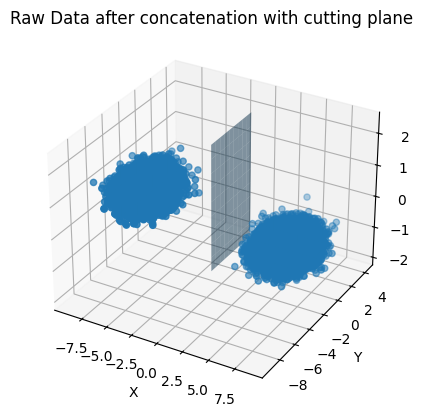

In [72]:
#create 3d plot of the data

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:,0], data[:,1], data[:,2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.title.set_text('Raw Data after concatenation')


mean_points = np.array([])
for i, cluster in enumerate(optigrid_test.clusters):
    cluster_data = np.take(data, cluster, axis=0) # Clusters are stored as indices pointing to the original data
    if mean_points.size == 0:
        mean_points = np.mean(cluster_data, axis=0)
    else:        
        mean_points= np.vstack((mean_points, np.mean(cluster_data, axis=0)))
    print("Cluster {}: Mean={}, Std={}".format(i, np.mean(cluster_data, axis=0), np.std(cluster_data, axis=0)))


#for i, mean_point in enumerate(mean_points):
#    ax.scatter(mean_point[0], mean_point[1], mean_point[2], c='r', marker='o')
#    ax.text(mean_point[0], mean_point[1], mean_point[2], 'Cluster {}'.format(i), color='black')

#ax.plot(mean_points[:,0], mean_points[:,1], mean_points[:,2], c='r')
#we will plot ax.plot_surface to show the cutting plane
#the dimension of the cutting plane is either the x plane, y plane or z plane which is determined by optigrid_test.root.cutting_plane[1]
#the fixed value in the dimension is determined by optigrid_test.root.cutting_plane[0]
#the range of the cutting plane is determined by optigrid_test.root.cutting_plane[2]

#plot all cutting planes
n_points = 10
cutting_planes = optigrid_test.root.cutting_planes
for cutting_plane in cutting_planes:
    if cutting_plane[1] == 0:
        x = cutting_plane[0] * np.ones(n_points)
        y = np.linspace(np.min(data_scaled[:,1]), np.max(data_scaled[:,1]), n_points)        
        z = np.linspace(np.min(data_scaled[:,2]), np.max(data_scaled[:,2]), n_points)
        y, z = np.meshgrid(y, z)
    elif cutting_plane[1] == 1:
        x =  np.linspace(np.min(data_scaled[:,0]), np.max(data_scaled[:,0]), n_points)
        y = cutting_plane[0] * np.ones(n_points)        
        z = np.linspace(np.min(data_scaled[:,2]), np.max(data_scaled[:,2]), n_points)
        x, z = np.meshgrid(x, z)
    else:
        x =  np.linspace(np.min(data_scaled[:,0]), np.max(data_scaled[:,0]), n_points)
        y = np.linspace(np.min(data_scaled[:,1]), np.max(data_scaled[:,1]), n_points)        
        z = cutting_plane[0] * np.ones(n_points)
        x, y = np.meshgrid(x, y)
    ax.plot_surface(x, y, z, alpha=0.5)
    ax.title.set_text('Raw Data after concatenation with cutting plane')


plt.show()

Cluster 0: Mean=[-4.99952103 -5.01726468  1.00270976], Std=[0.99936314 1.00773337 0.22413538]
Cluster 1: Mean=[ 5.00122262  0.00909679 -1.00011646], Std=[1.00554963 1.00470017 0.22381839]


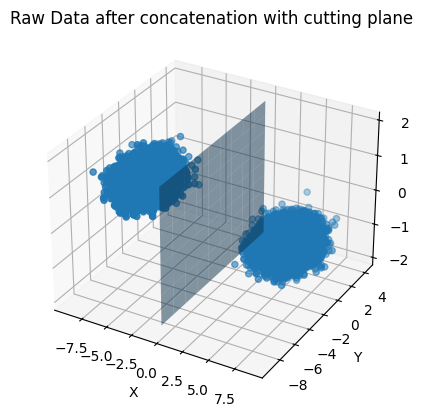

In [73]:
#create 3d plot of the data

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:,0], data[:,1], data[:,2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.title.set_text('Raw Data after concatenation')


mean_points = np.array([])
for i, cluster in enumerate(optigrid_test.clusters):
    cluster_data = np.take(data, cluster, axis=0) # Clusters are stored as indices pointing to the original data
    if mean_points.size == 0:
        mean_points = np.mean(cluster_data, axis=0)
    else:        
        mean_points= np.vstack((mean_points, np.mean(cluster_data, axis=0)))
    print("Cluster {}: Mean={}, Std={}".format(i, np.mean(cluster_data, axis=0), np.std(cluster_data, axis=0)))


#for i, mean_point in enumerate(mean_points):
#    ax.scatter(mean_point[0], mean_point[1], mean_point[2], c='r', marker='o')
#    ax.text(mean_point[0], mean_point[1], mean_point[2], 'Cluster {}'.format(i), color='black')

#ax.plot(mean_points[:,0], mean_points[:,1], mean_points[:,2], c='r')
#we will plot ax.plot_surface to show the cutting plane
#the dimension of the cutting plane is either the x plane, y plane or z plane which is determined by optigrid_test.root.cutting_plane[1]
#the fixed value in the dimension is determined by optigrid_test.root.cutting_plane[0]
#the range of the cutting plane is determined by optigrid_test.root.cutting_plane[2]

#plot all cutting planes
n_points = 10
cutting_planes = optigrid_test.root.cutting_planes
for cutting_plane in cutting_planes:
    if cutting_plane[1] == 0:
        x = cutting_plane[0] * np.ones(n_points)
        y = np.linspace(np.min(data[:,1]), np.max(data[:,1]), n_points)        
        z = np.linspace(np.min(data[:,2]), np.max(data[:,2]), n_points)
        y, z = np.meshgrid(y, z)
    elif cutting_plane[1] == 1:
        x =  np.linspace(np.min(data[:,0]), np.max(data[:,0]), n_points)
        y = cutting_plane[0] * np.ones(n_points)        
        z = np.linspace(np.min(data[:,2]), np.max(data[:,2]), n_points)
        x, z = np.meshgrid(x, z)
    else:
        x =  np.linspace(np.min(data[:,0]), np.max(data[:,0]), n_points)
        y = np.linspace(np.min(data[:,1]), np.max(data[:,1]), n_points)        
        z = cutting_plane[0] * np.ones(n_points)
        x, y = np.meshgrid(x, y)
    ax.plot_surface(x, y, z, alpha=0.5)
    ax.title.set_text('Raw Data after concatenation with cutting plane')


plt.show()

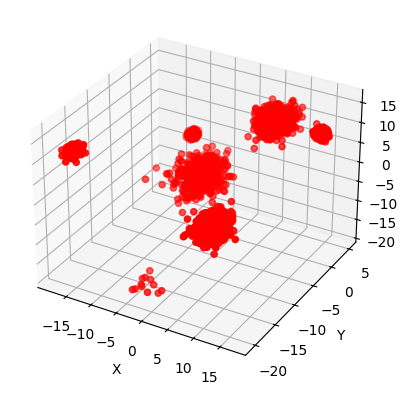

In [86]:
import matplotlib.pyplot as plt
import numpy as np
import string
from sklearn.decomposition import PCA


def generate_cluster_centers(num_clusters, min_val, max_val):
    cluster_centers = np.random.uniform(min_val, max_val, size=(num_clusters, 3))    
    return cluster_centers

def generate_cluster_data(cluster_centers, num_points, mean_distance, std_dev, cluster_label_set=None, random_std= False, random_total_points=False):
    cluster_data = []
    labels = []


    for ix, center in enumerate(cluster_centers):
        
        if random_std == True:
            std_dev_distance = np.random.uniform(0, std_dev)
        else:
            std_dev_distance = std_dev
        
        if random_total_points==True:            
            total_points = np.random.randint(0, num_points)
        else:
            total_points = num_points

        points = np.random.normal(loc=center, scale=std_dev_distance, size=(total_points, 3))
        labels.extend([cluster_label_set[ix]] * total_points)
        cluster_data.append(points)
    return np.concatenate(cluster_data), labels

def generate_cluster_labels(num_clusters):
    alphabet = string.ascii_uppercase
    labels = []
    for i in range(num_clusters):
        if i < 26:
            label = alphabet[i]
        else:
            label = f"{alphabet[i % 26]}{i // 26}"
        labels.extend([label] )
    return labels



num_clusters = 7
min_val = -20   # min and max values for the cluster centers
max_val = 20
total_points = 1000
mean_distance = 9.0
std_dev_distance = 2

# Generate cluster labels
cluster_label_set = generate_cluster_labels(num_clusters)
cluster_centers = generate_cluster_centers(num_clusters, min_val, max_val)
cluster_data, cluster_labels = generate_cluster_data(cluster_centers, total_points, mean_distance, std_dev_distance, cluster_label_set,True, True)

# Plotting the clusters in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2], c='r', marker='o')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()


# Attach cluster labels to each datapoint
labeled_cluster_data = np.column_stack((cluster_data, cluster_labels))
raw_data = np.copy(cluster_data)


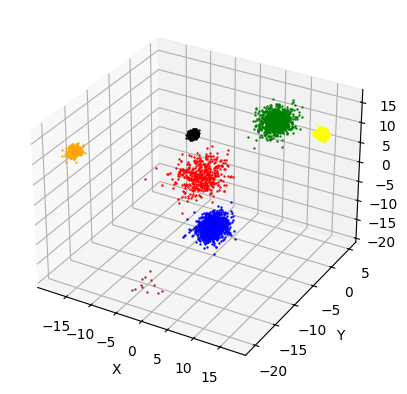

In [87]:
import matplotlib.pyplot as plt

# Define the resistor color code colors
colors = ['black', 'brown', 'red', 'orange', 'yellow', 'green', 'blue', 'violet', 'gray', 'white']

# Plotting the clusters in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Assign a unique color to each cluster
unique_labels = set(cluster_labels)
num_clusters = len(unique_labels)
#map colors to cluster labels by creating a dictionary
#loop through number of clusters and assign a color to each cluster using the colors list and cluster index mod 10
color_map = dict(zip(unique_labels, [colors[i % 10] for i in range(num_clusters)]))


# Plot each data point with its corresponding cluster color
for i, label in enumerate(cluster_labels):
    ax.scatter(cluster_data[i, 0], cluster_data[i, 1], cluster_data[i, 2], c=color_map[label], marker='o', s=0.5)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()


In [76]:
print(cluster_data.shape)
print(data.shape)

(6674, 3)
(30000, 3)


In [93]:
import numpy as np
import matplotlib.pyplot as plt
from optigrid import optigrid

# Weight the samples from the first population twice as high
weights = np.array([1] * cluster_data.shape[0])

# Now we want to standard scale our data. Although it is not necessary, it is recommended for better selection of the parameters and uniform importance of the dimensions.
cluster_data_scaled = (cluster_data - np.mean(cluster_data, axis=0)) / np.std(cluster_data, axis=0)

# Next, chose the parameters
d = 3 # Number of dimensions
q = 1 # Number of cutting planes per step
noise_level = 0.1
max_cut_score = 0.3
bandwidth = 0.1

# Fit Optigrid to the data
optigrid_test = optigrid.Optigrid(d=d, q=q, max_cut_score=max_cut_score, noise_level=noise_level, kde_bandwidth=bandwidth, verbose=True)
optigrid_test.fit(cluster_data_scaled, weights=weights)


for i, cluster in enumerate(optigrid_test.clusters):
    cluster_data_i = np.take(cluster_data_scaled, cluster, axis=0) # Clusters are stored as indices pointing to the original data
    print("Cluster {}: Mean={}, Std={}".format(i, np.mean(cluster_data_i, axis=0), np.std(cluster_data_i, axis=0)))


min_val=-2.1580150132626086, max_val=1.3430236249777885
min_val=-2.275230424596251, max_val=1.150502828704863
min_val=-3.824185987497898, max_val=1.808103961417804
Found following cuts: [(0.21513306677497868, 2, 0.0010792560346192777)]
Evaluating subgrid: 54.60% of datapoints
min_val=-1.4836622463275528, max_val=0.7026958857217095
min_val=-2.275230424596251, max_val=0.9463127957455888
min_val=-3.824185987497898, max_val=0.20555064920929397
Found following cuts: [(0.4256593459933722, 1, 0.00474191650492487)]
Evaluating subgrid: 32.33% of datapoints
min_val=-1.345973182852171, max_val=0.7026958857217095
min_val=-2.275230424596251, max_val=0.4046263511376924
min_val=-3.824185987497898, max_val=0.20555064920929397
Found following cuts: [(-0.9488366669097537, 1, 0.01855997208355697)]
Evaluating subgrid: 22.61% of datapoints
min_val=-0.7854225897068047, max_val=0.8655272205129599
min_val=-2.275230424596251, max_val=-0.9573854265888022
min_val=-3.824185987497898, max_val=-0.1832915069156034
F

branch node - [(0.21513306677497868, 2, 0.0010792560346192777)], side=-1, d_prev=-1, x0=-2.158, x1=1.356, y0=-2.294, y1=1.151
branch node - [(0.4256593459933722, 1, 0.00474191650492487)], side=0, d_prev=2, x0=-2.158, x1=1.356, y0=-2.294, y1=1.151
branch node - [(-0.9488366669097537, 1, 0.01855997208355697)], side=0, d_prev=1, x0=-2.158, x1=1.356, y0=-2.294, y1=0.426
leaf node - 0, side=0, d_prev=1, x0=-2.158, x1=1.356, y0=-2.294, y1=-0.949, z0=-3.824, z1=0.215
leaf node - 1, side=1, d_prev=1, x0=-2.158, x1=1.356, y0=-0.949, y1=0.426, z0=-3.824, z1=0.215
leaf node - 2, side=1, d_prev=1, x0=-2.158, x1=1.356, y0=0.426, y1=1.151, z0=-3.824, z1=0.215
branch node - [(-0.9160077520325707, 0, 7.848097970246362e-21)], side=1, d_prev=2, x0=-2.158, x1=1.356, y0=-2.294, y1=1.151
leaf node - 3, side=0, d_prev=0, x0=-2.158, x1=-0.916, y0=-2.294, y1=1.151, z0=0.215, z1=1.870
branch node - [(0.8728907650378196, 0, 0.014212507569755756)], side=1, d_prev=0, x0=-0.916, x1=1.356, y0=-2.294, y1=1.151
leaf 

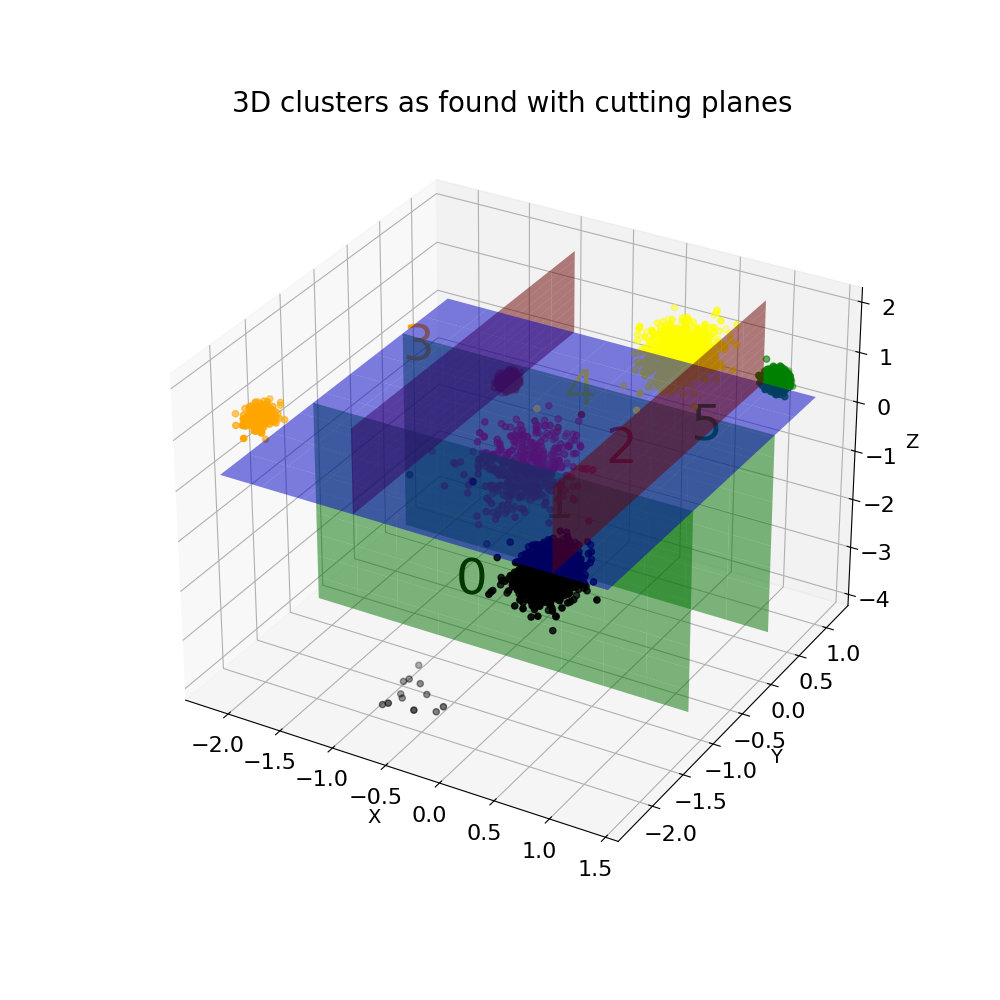

In [109]:
#create 3d plot of the data
%matplotlib widget
 
# importing required libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

plane_colors = ['r', 'g', 'b']

def plot_cutting_planes_3d(ax, node, side, d_prev, x0, x1, y0, y1, z0, z1):       
    if node is None:         
        return
        
    if  node.cutting_planes is None:
        print(f'leaf node - {node.cluster_index}, {side=}, {d_prev=}, {x0=:1.3f}, {x1=:1.3f}, {y0=:1.3f}, {y1=:1.3f}, {z0=:1.3f}, {z1=:1.3f}')
        ax.text((x0+x1)/2, (y0+y1)/2, (z0+z1)/2, f'{node.cluster_index}', color=colors[node.cluster_index%10], fontsize=36)      
        return
    else:
        print(f'branch node - {node.cutting_planes}, {side=}, {d_prev=}, {x0=:1.3f}, {x1=:1.3f}, {y0=:1.3f}, {y1=:1.3f}')
            
    for cutting_plane in node.cutting_planes:
        if cutting_plane[1] == 0:
            x = cutting_plane[0] * np.ones((n_points, n_points))
            y = np.linspace(y0, y1, n_points)        
            z = np.linspace(z0, z1, n_points)            
            y, z = np.meshgrid(y, z)
        elif cutting_plane[1] == 1:
            x =  np.linspace(x0, x1, n_points)
            y = cutting_plane[0] * np.ones((n_points,n_points))        
            z = np.linspace(z0, z1, n_points)            
            x, z = np.meshgrid(x, z)            
        elif cutting_plane[1] == 2:
            x =  np.linspace(x0, x1, n_points)
            y = np.linspace(y0, y1, n_points)        
            z = cutting_plane[0] * np.ones((n_points,n_points))            
            x, y = np.meshgrid(x, y)
            
        
        ax.plot_surface(x, y, z, alpha=0.5, color=plane_colors[cutting_plane[1]])               
                  
            
        for child_side, child in enumerate(node.subgrids):
            if child_side == 0:
                if cutting_plane[1] == 0:
                    plot_cutting_planes_3d(ax, child, child_side, cutting_plane[1], x0, cutting_plane[0], y0, y1, z0, z1)
                elif cutting_plane[1] == 1:
                    plot_cutting_planes_3d(ax, child, child_side, cutting_plane[1], x0, x1, y0, cutting_plane[0], z0, z1)
                elif cutting_plane[1] == 2:
                    plot_cutting_planes_3d(ax, child, child_side, cutting_plane[1], x0, x1, y0, y1, z0, cutting_plane[0])            
            else:
                if cutting_plane[1] == 0:
                    plot_cutting_planes_3d(ax, child, child_side, cutting_plane[1], cutting_plane[0], x1, y0, y1, z0, z1)
                elif cutting_plane[1] == 1:
                    plot_cutting_planes_3d(ax, child, child_side, cutting_plane[1], x0, x1, cutting_plane[0], y1, z0, z1)
                elif cutting_plane[1] == 2:
                    plot_cutting_planes_3d(ax, child, child_side, cutting_plane[1], x0, x1, y0, y1, cutting_plane[0], z1)
        
  
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(cluster_data_scaled[:,0], cluster_data_scaled[:,1], cluster_data_scaled[:,2])
for index, cluster in enumerate(optigrid_test.clusters):
    ax.scatter(cluster_data_scaled[cluster,0], cluster_data_scaled[cluster,1], cluster_data_scaled[cluster,2], label=f'Cluster {index}', color=colors[index%10])
ax.set_xlabel('X', fontsize=14)
ax.tick_params(axis='x', labelsize=16)

ax.set_ylabel('Y', fontsize=14)
ax.tick_params(axis='y', labelsize=16)

ax.set_zlabel('Z', fontsize=14)
ax.tick_params(axis='z', labelsize=16)

ax.title.set_text('3D clusters as found with cutting planes')
ax.title.set_fontsize(20)


plot_cutting_planes_3d(ax, optigrid_test.root, side=-1, d_prev=-1, x0=np.min(cluster_data_scaled[:,0]), x1=np.max(cluster_data_scaled[:,0]), y0=np.min(cluster_data_scaled[:,1]), y1=np.max(cluster_data_scaled[:,1]), z0=np.min(cluster_data_scaled[:,2]), z1=np.max(cluster_data_scaled[:,2]))

#we will plot ax.plot_surface to show the cutting plane
#the dimension of the cutting plane is either the x plane, y plane or z plane which is determined by optigrid_test.root.cutting_plane[1]
#the fixed value in the dimension is determined by optigrid_test.root.cutting_plane[0]
#the range of the cutting plane is determined by optigrid_test.root.cutting_plane[2]

#rotate the plot to see the cutting planes



plt.show()

In [115]:
import numpy as np
import matplotlib.pyplot as plt


from optigrid import optigrid


#random seed 42
np.random.seed(42)


# First, generate two separate normal distributions and noise
normal1_mean = [-5, -5]
normal1_cov = [[1, 0], [0, 1]]
normal1_samples = 10000
normal1 = np.random.multivariate_normal(mean=normal1_mean, cov=normal1_cov, size=normal1_samples)

normal2_mean = [5, 0]
normal2_cov = [[1, 0.2], [0.2, 1]]
normal2_samples = 20000
normal2 = np.random.multivariate_normal(mean=normal2_mean, cov=normal2_cov, size=normal2_samples)

normal3_mean = [0, 5]
normal3_cov = [[1, 0.2], [0.2, 1]]
normal3_samples = 20000
normal3 = np.random.multivariate_normal(mean=normal3_mean, cov=normal3_cov, size=normal3_samples)

normal4_mean = [-7, 20]
normal4_cov = [[1, 0.1], [.1, 1]]
normal4_samples = 20000
normal4 = np.random.multivariate_normal(mean=normal4_mean, cov=normal4_cov, size=normal4_samples)


noise_low = [-25, -25]
noise_high = [25, 25]
noise_samples = 1000
noise = np.random.uniform(low=noise_low, high=noise_high, size=(noise_samples, 2))

data = np.concatenate((normal1, normal2, normal3, normal4, noise))

# Weight the samples from the first population twice as high
weights = np.array([1] * normal1_samples + [1] * normal2_samples + [1] * normal3_samples + [1] * normal4_samples + [1] * noise_samples)

# Now we want to standard scale our data. Although it is not necessary, it is recommended for better selection of the parameters and uniform importance of the dimensions.
data_scaled = (data - np.mean(data, axis=0)) / np.std(data, axis=0)

# Next, chose the parameters
d = 2 # Number of dimensions
q = 1 # Number of cutting planes per step
noise_level = 0.1
max_cut_score = 1
bandwidth = 0.2

# Fit Optigrid to the data
optigrid_test = optigrid.Optigrid(d=d, q=q, max_cut_score=max_cut_score, noise_level=noise_level, kde_bandwidth=bandwidth, verbose=False)
optigrid_test.fit(data_scaled, weights=weights)
### Output: 
###     In current cluster: 47.08% of datapoints
###     In current cluster: 52.92% of datapoints
###     Optigrid found 2 clusters.

for i, cluster in enumerate(optigrid_test.clusters):
    cluster_data = np.take(data, cluster, axis=0) # Clusters are stored as indices pointing to the original data
    print("Cluster {}: Mean={}, Std={}".format(i, np.mean(cluster_data, axis=0), np.std(cluster_data, axis=0)))
### Output: 
###     Cluster 0: Mean=[-5.03474967 -3.3355985   0.6569438 ], Std=[1.79700025 4.11403245 3.33377444]
###     Cluster 1: Mean=[ 4.92505754  0.05634452 -0.62898176], Std=[1.92237979 3.49116619 3.46671477]

# Draw a 10 values from both normals and score it with optigrid after normalization
sample_size = 10
sample1 = np.random.multivariate_normal(normal1_mean, normal1_cov, sample_size)
sample2 = np.random.multivariate_normal(normal2_mean, normal2_cov, sample_size)
sample = np.concatenate((sample1, sample2))
sample = (sample - np.mean(data)) / np.std(data)

result = optigrid_test.score_samples(sample)
print(result)
### Output: 
###     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
### The first ten values belong to the zeroth cluster and the latter ten to the second cluster as expected

Cluster 0: Mean=[-5.30674848 -4.93183847], Std=[2.18826115 2.39365428]
Cluster 1: Mean=[-1.42261469e-03  4.86606104e+00], Std=[1.00196589 1.56515854]
Cluster 2: Mean=[ 5.17203765 -0.09052369], Std=[1.7611895  1.93386058]
Cluster 3: Mean=[-6.90218547 19.97316353], Std=[2.06304488 1.0766038 ]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


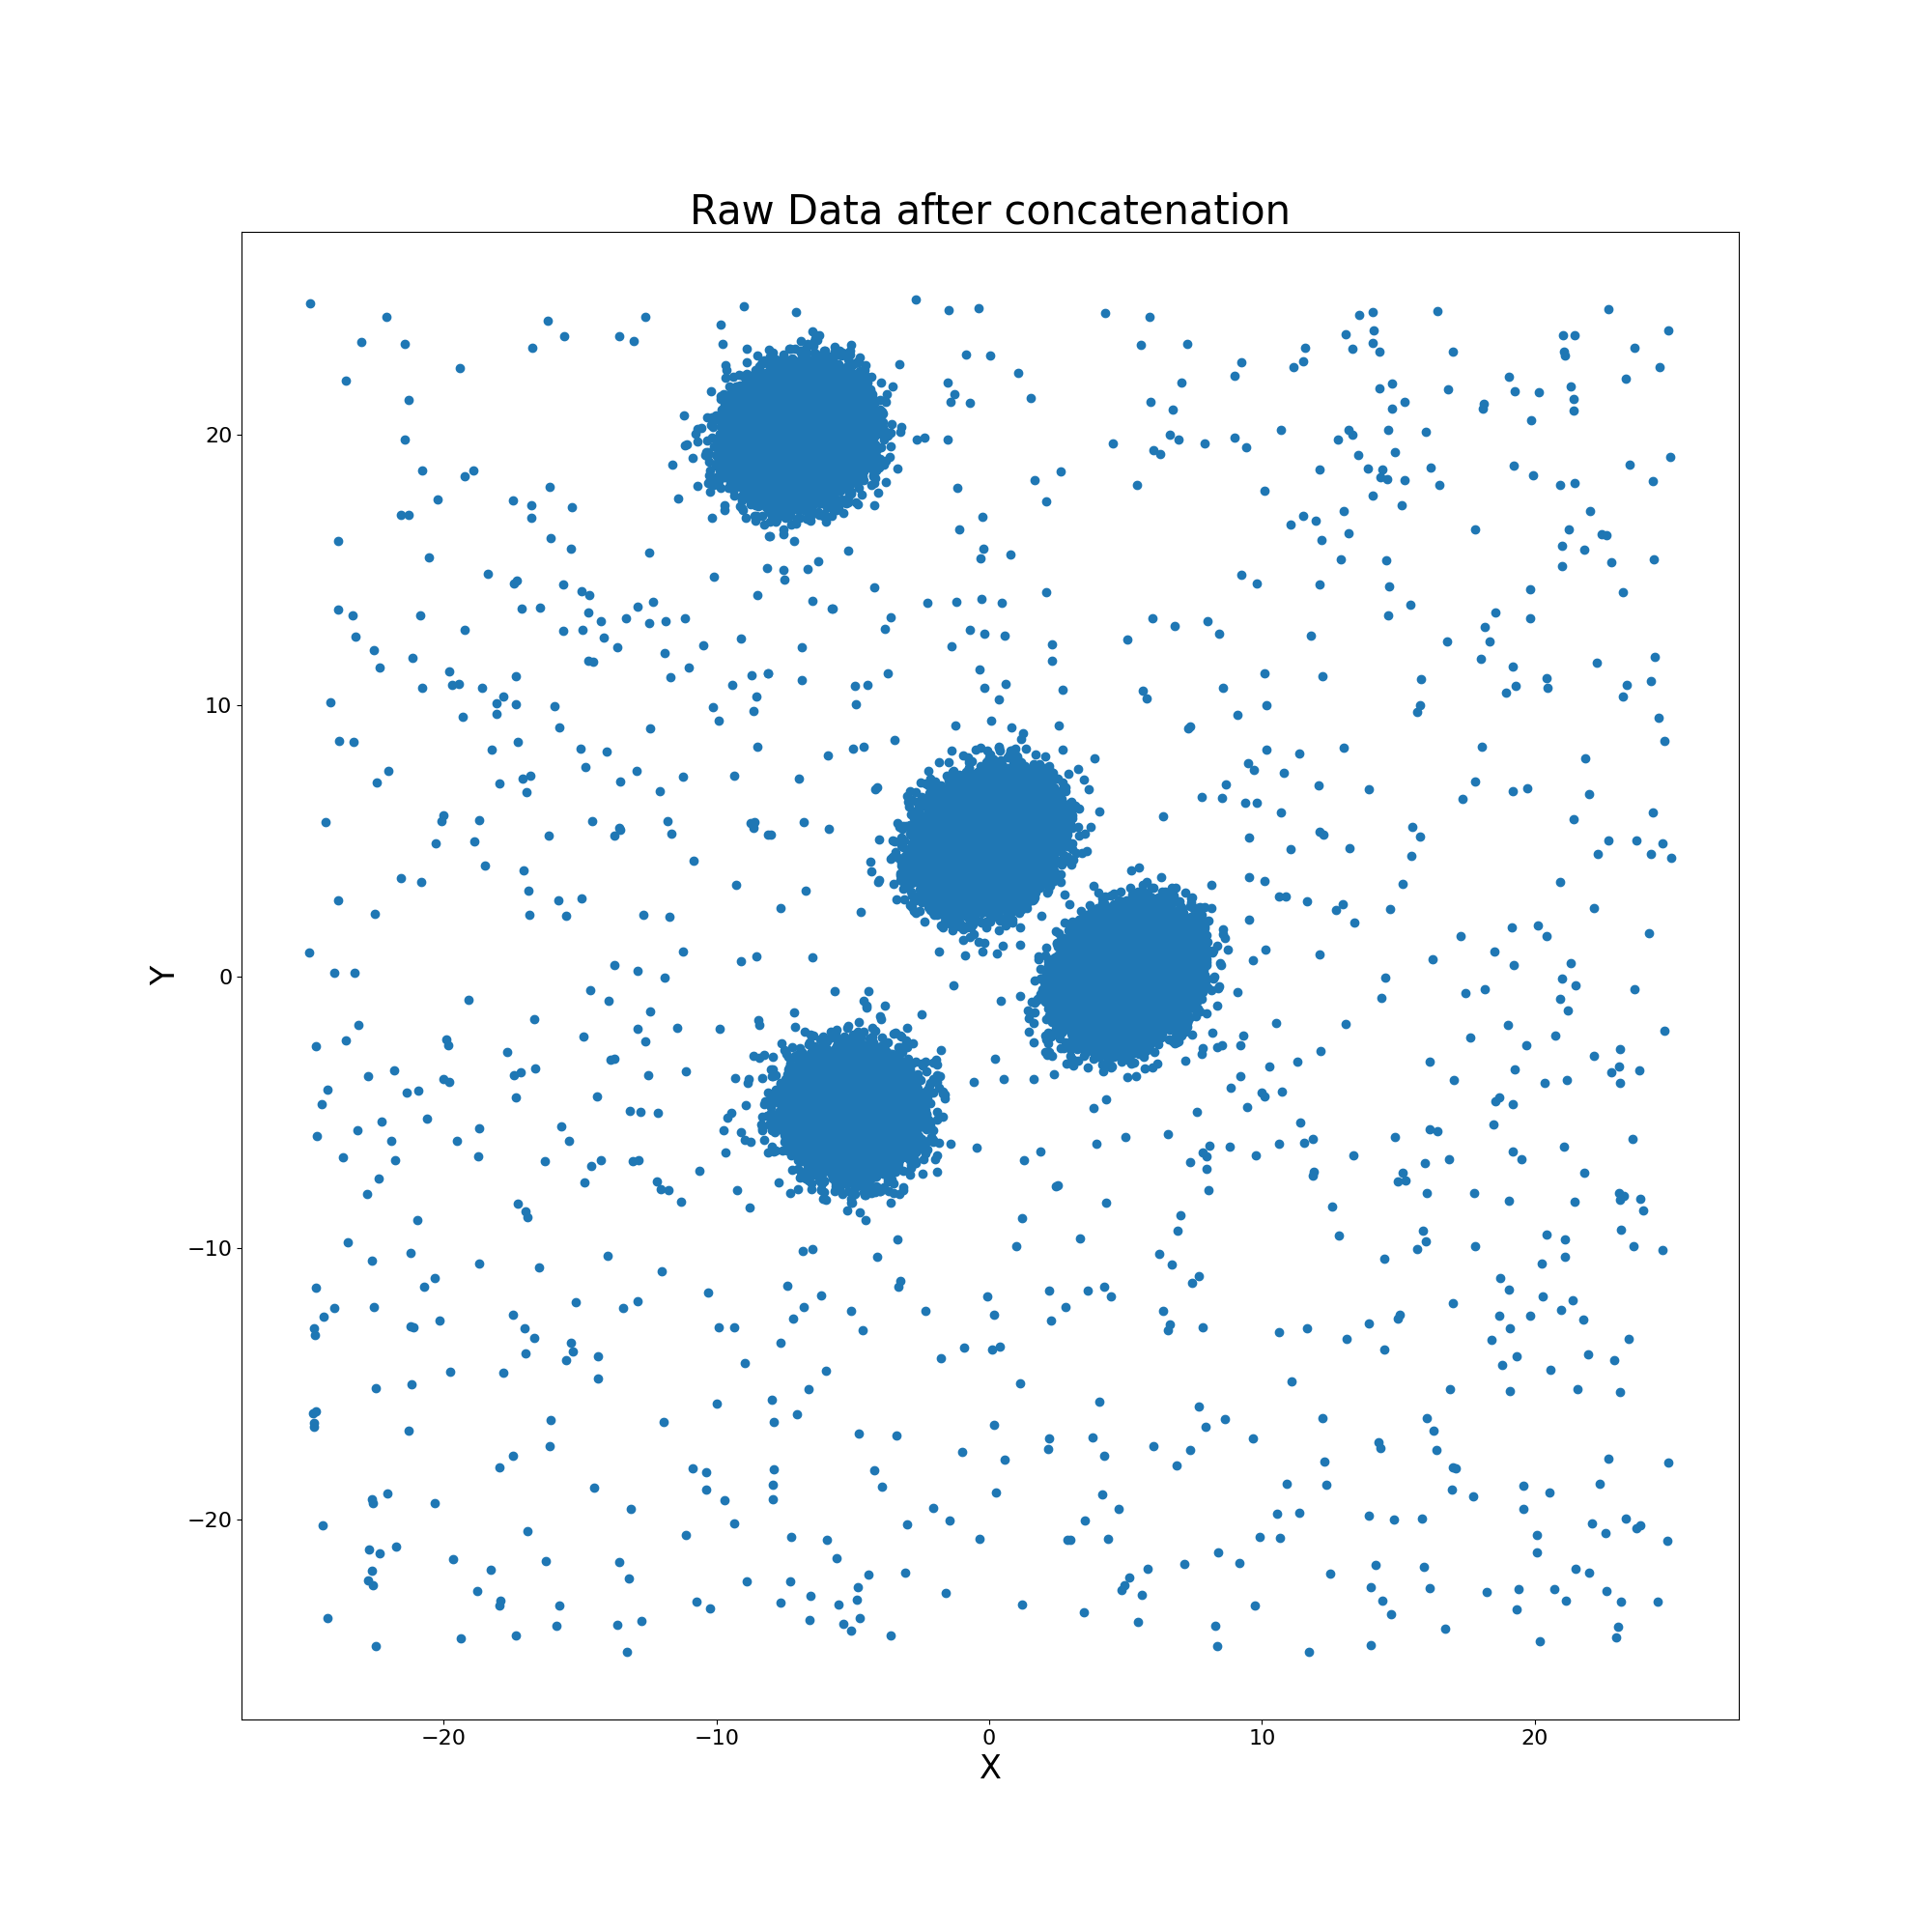

C:\Users\krisr\AppData\Local\Temp\ipykernel_17076\4182797244.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(20,20))


branch node - [(0.6767588285142767, 1, 0.004818754338053006)], side=-1, d_prev=-1, x0=-4.571, x1=5.072, y0=-3.352, y1=2.001
branch node - [(-0.282183815427306, 0, 0.125756342779702)], side=0, d_prev=1, x0=-4.571, x1=5.072, y0=-3.352, y1=0.677
leaf node - 0, side=0, d_prev=0, x0=-4.571, x1=-0.282, y0=-3.352, y1=0.677
branch node - [(0.7402296431389069, 0, 0.17762294245182766)], side=1, d_prev=0, x0=-0.282, x1=5.072, y0=-3.352, y1=0.677
leaf node - 1, side=0, d_prev=0, x0=-0.282, x1=0.740, y0=-3.352, y1=0.677
leaf node - 2, side=1, d_prev=0, x0=0.740, x1=5.072, y0=-3.352, y1=0.677
leaf node - 3, side=1, d_prev=1, x0=-4.571, x1=5.072, y0=0.677, y1=2.001


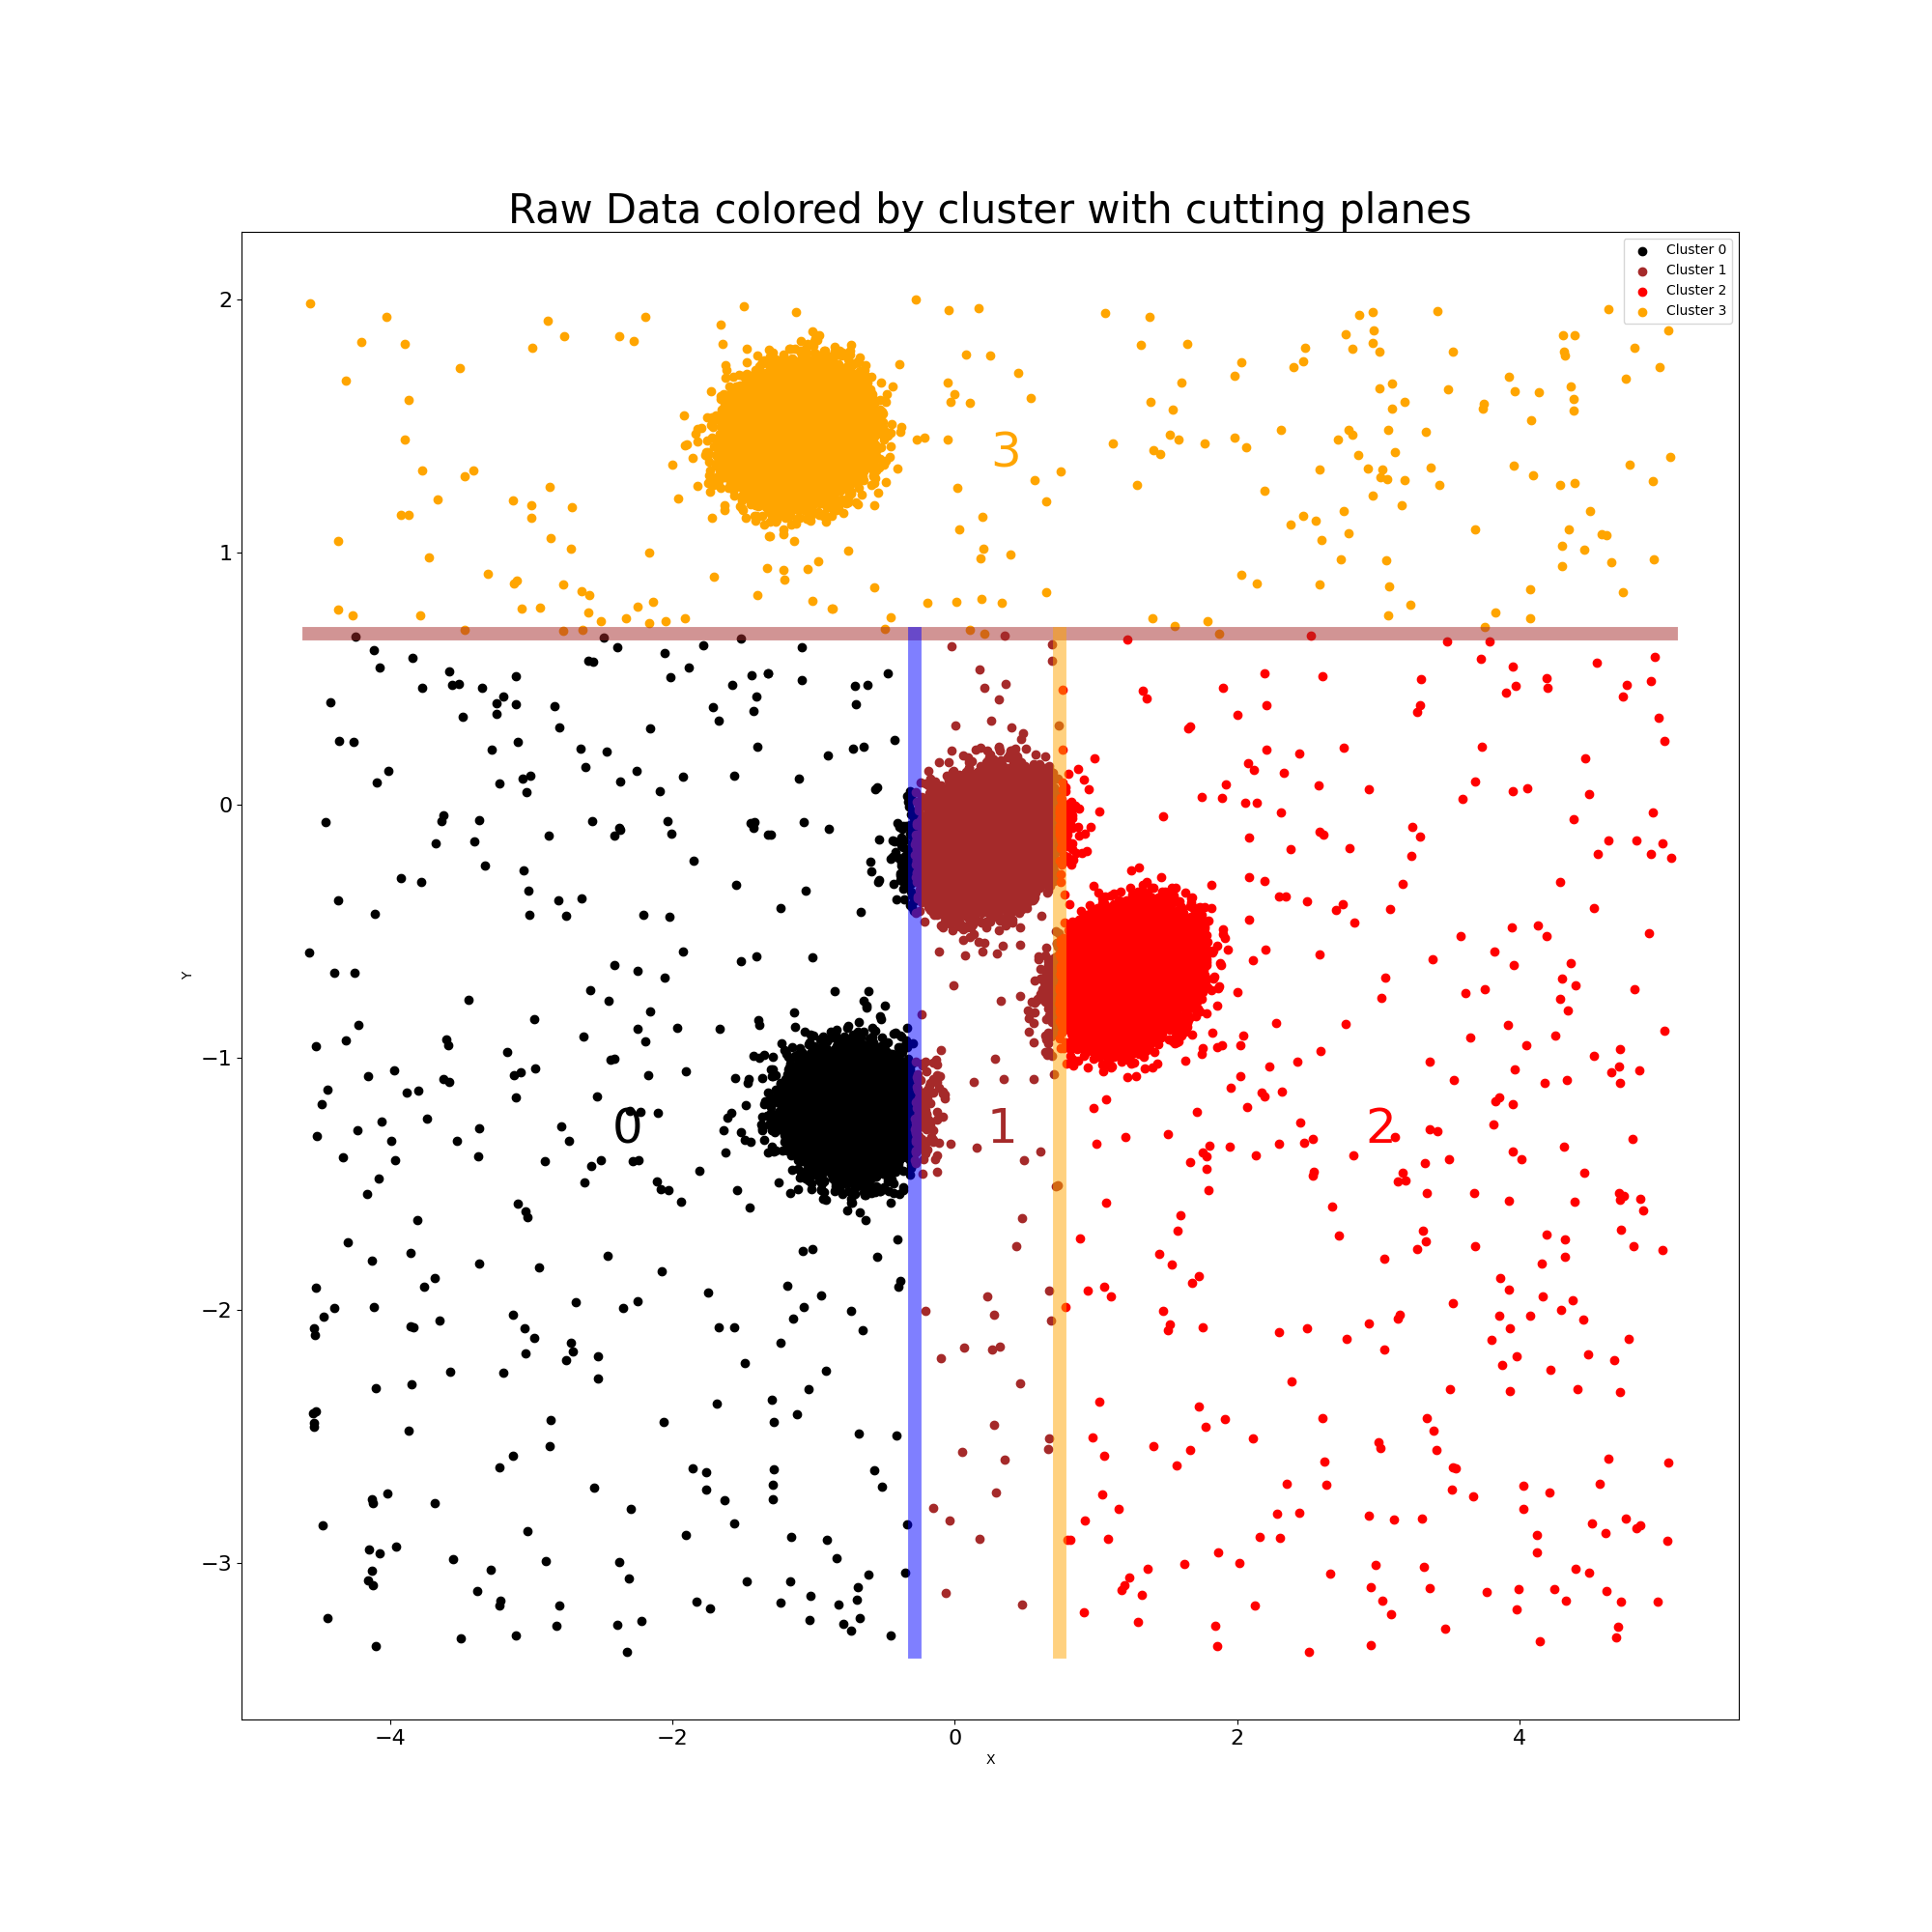

In [120]:
#create 3d plot of the data

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
ax.scatter(data[:,0], data[:,1])
ax.set_xlabel('X', fontsize=24)
#set x_label fontsize

ax.set_ylabel('Y', fontsize=24)

ax.title.set_text('Raw Data after concatenation')
ax.title.set_fontsize(30)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.show()

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
for index, cluster in enumerate(optigrid_test.clusters):
    ax.scatter(data_scaled[cluster,0], data_scaled[cluster,1], label=f'Cluster {index}', color=colors[index%10])
ax.set_xlabel('X')
#set x_label fontsize
ax.set_ylabel('Y')
ax.legend()
ax.title.set_text('Raw Data colored by cluster with cutting planes')


#set title font size




#plot all cutting planes
    
#recursively plot all cutting planes. Starting with the root node then traverse the tree to plot all cutting planes

def plot_cutting_planes(ax, node, side, d_prev, x0, x1, y0, y1):       
    if node is None:         
        return
        
    if  node.cutting_planes is None:
        print(f'leaf node - {node.cluster_index}, {side=}, {d_prev=}, {x0=:1.3f}, {x1=:1.3f}, {y0=:1.3f}, {y1=:1.3f}')
        ax.text((x0+x1)/2, (y0+y1)/2, f'{node.cluster_index}', color=colors[node.cluster_index%10], fontsize=36)      
        return
    else:
        print(f'branch node - {node.cutting_planes}, {side=}, {d_prev=}, {x0=:1.3f}, {x1=:1.3f}, {y0=:1.3f}, {y1=:1.3f}')
            
    for cutting_plane in node.cutting_planes:
        if cutting_plane[1] == 0:
            x = cutting_plane[0] * np.ones(n_points)
            y = np.linspace(y0, y1, n_points )
                        
            if side == 0: #left                
                ax.plot(x, y, alpha=0.5, c='blue', linewidth=10)
                #ax.text(x[0], (y0+y1)/2, f'{cutting_plane[0]:.1f}', color='black')
            else:
              
                ax.plot(x, y, alpha=0.5, c='orange', linewidth=10)
                #ax.text(x[0], (y0+y1)/2, f'{cutting_plane[0]:.1f}', color='red')

        elif cutting_plane[1] == 1:
            x =  np.linspace(x0, x1, n_points)
            y = cutting_plane[0] * np.ones(n_points)                                   
            
            if side == 0: #bottom              
                ax.plot(x, y, alpha=0.5, c='green', linewidth=10)
                #ax.text((x0+x1)/2, y[0], f'{cutting_plane[0]:.1f}', color='black')
            else:               
                ax.plot(x, y, alpha=0.5, c='brown', linewidth=10)
                #ax.text((x0+x1)/2, y[0], f'{cutting_plane[0]:.1f}', color='red')               
                  
            
        for child_side, child in enumerate(node.subgrids):
            if child_side == 0:
                if cutting_plane[1] == 0:
                    plot_cutting_planes(ax, child, child_side, cutting_plane[1], x0, cutting_plane[0], y0, y1)
                elif cutting_plane[1] == 1:
                    plot_cutting_planes(ax, child, child_side, cutting_plane[1], x0, x1, y0, cutting_plane[0])
            else:
                if cutting_plane[1] == 0:
                    plot_cutting_planes(ax, child, child_side, cutting_plane[1], cutting_plane[0], x1, y0, y1)
                elif cutting_plane[1] == 1:
                    plot_cutting_planes(ax, child, child_side, cutting_plane[1], x0, x1, cutting_plane[0], y1)
        
  
plot_cutting_planes(ax, optigrid_test.root, side=-1, d_prev=-1, x0=np.min(data_scaled[:,0]), x1=np.max(data_scaled[:,0]), y0=np.min(data_scaled[:,1]), y1=np.max(data_scaled[:,1]))
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.title.set_fontsize(30)

plt.show()